Playing with Arka's VPF code. Trying to understand it and ultimately put it into halotools. 

In [1]:
import numpy as np
from scipy import spatial, interpolate
from scipy.stats import percentileofscore
from pearce.mocks.kittens import TrainingBox
from time import time

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
def CDFVolkNN(vol):
    N = vol.shape[0]
    gof = ((np.arange(0, N) + 1) / (N*1.0))

    ind = np.argsort(vol)
    sVol= vol[ind]
    print sVol.shape, gof.shape, N
    # return array of interpolating functions
    CDF = interpolate.interp1d(sVol,gof, kind='linear', \
                                        bounds_error=False)
    return CDF

In [4]:
def my_CDFVolkNN(vol, binc):
   
    sVol= np.sort(vol)
    CDF =  np.searchsorted(sVol, binc)
    
    return CDF/float(vol.shape[0])

In [116]:
def VDF(halo_table, nrandoms,cat, bins):
    t0=time()
    halo_pos = np.stack(halo_table['halo_%s'%coord] for coord in ['x', 'y', 'z']).T
    #print halo_pos.shape

    #Build Tree with halo positions
    periodic=0 # TODO whats this do?

    #Generate  nrandoms randoms on the same volume
    random_pos = np.random.rand(nrandoms,3)*cat.Lbox
    # Leaf size from 16-. 256 slowed down queery time a lot
    # flipping the defintion the other way doesnt work
    #xtree = spatial.cKDTree(halo_pos, boxsize=periodic, leafsize = 256)
    xtree = spatial.cKDTree(halo_pos, boxsize=periodic, leafsize = 16)

    #Get nearest neighbor distance
    dis, disi = xtree.query(random_pos, k=1, eps = 1.0, n_jobs=-1)
    vol = dis

    #Define the bins
    binw = bins[1:] - bins[:-1]
    binc = (bins[1:] + bins[:-1]) / 2
    #Now get the VPF
    #CDFs = CDFVolkNN(vol)
    dummyvpf = my_CDFVolkNN(vol, binc)

    #Remove NaN from outside interpolation region
    #dummyvpf[np.isnan(dummyvpf)] = 1.0
    #return CDFs, dummyvpf
    return dummyvpf

In [73]:
cat = TrainingBox(0)

In [74]:
cat.load_catalog(1.0)

In [75]:
len(cat.halocat.halo_table)

10055159

In [102]:
nrandoms = 100**3
Boxsize = cat.Lbox

n1 = 3000 #Number of data points to subsample down to.
           #For analysis on 10Mpc-50Mpc scales, a range of 30000<n1<90000
           #seems optimal. For pushing to lower scales, you can try increasing
           #n1 and see if you get more information.

Ncut = 100000 #Rank on halo mass list to go down to.


In [103]:
halo_masses = cat.halocat.halo_table['halo_mvir']

In [104]:
mass_idxs = np.argsort(halo_masses)

In [105]:
cut_idxs = mass_idxs[-Ncut:]

In [106]:
halo_table = cat.halocat.halo_table[cut_idxs]

In [107]:
bins = np.logspace(-1, 1.8, 1000)

In [108]:
sim_vpf_n1 = VDF(halo_table, Ncut*10,cat, bins)

A 0.00191688537598
B 0.111558914185
C 0.577996969223
D 0.671555042267


/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


In [109]:
#interpolator, vpf = sim_vpf_n1
vpf = sim_vpf_n1

In [110]:
binc = (bins[1:] + bins[:-1]) / 2

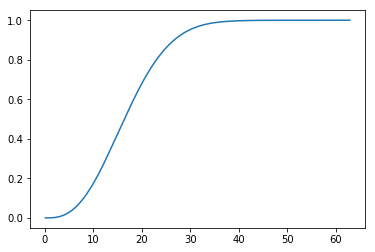

In [111]:
plt.plot(binc, vpf);
#plt.xscale('log')

In [112]:
len(mass_idxs)

10055159

1e+14
55532
1e+13
946302
1e+12
6453631
1e+11
10019345


/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


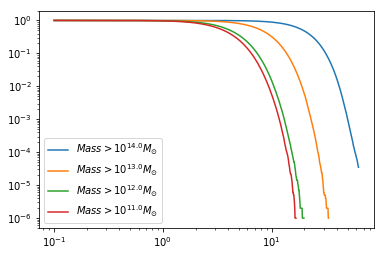

In [124]:
for mass_cut in [1e14, 1e13,1e12,1e11]:
    print mass_cut
    cut_idxs = np.where(halo_masses>mass_cut)[0]
    halo_table = cat.halocat.halo_table[cut_idxs]
    print len(halo_table)
    vpf = VDF(halo_table, Ncut*10,cat, bins)
    plt.plot(binc, 1-vpf, label = r'$Mass > 10^{%0.1f} M_{\odot}$'%np.log10(mass_cut));
plt.legend(loc='best')
#plt.xscale('log')
plt.loglog()
plt.show();